In [67]:
#!g1.1
%pip install -r requirements.txt
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torch import optim
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import optuna
from optuna.trial import TrialState

import numpy as np
import pandas as pd

import random as rnd
import os
import math
import shutil
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm, trange
from cairosvg import svg2png
from IPython import display

import utils.dataloader as dl
from utils.svg import SVG
import umap
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
#!g1.4
device = "cuda" if torch.cuda.is_available() else "cpu"

SVG.ENCODE_HEIGHT = 32
# fonts_number = 100
# fonts_number = 8000
fonts_number = None

print(f'Device: {device}')

Device: cuda


## Загрузка данных

In [3]:
dataset_train = dl.FontsDataset(test=False, download=True)
dataset_test = dl.FontsDataset(test=True)

In [4]:
train_dataloader = DataLoader(dataset_train, batch_size=512, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=512, shuffle=True, num_workers=0)

('five', '!the_black_bloc-bold')


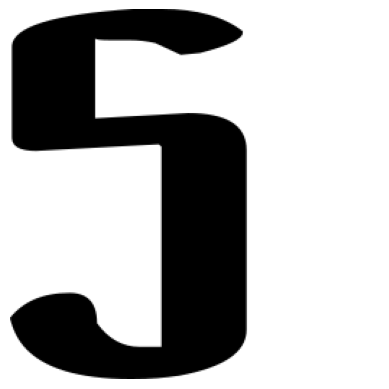

In [5]:
def save_sampled(x: np.ndarray, name):
    file = Path('imgs') / name
    file.parent.mkdir(parents=True, exist_ok=True)
    svg = SVG.decode(x, path=file)
    svg.dump_to_file()

def show_sampled(x: np.ndarray, axis=None):
    if axis is None:
        axis = plt
    svg = SVG.decode(x)
    svg.mulsize(256)
    svg2png(bytestring=svg.dump(), write_to='imgs/tmp.png')
    img = mpimg.imread('imgs/tmp.png')
    axis.axis('off')
    axis.imshow(img)
    
print(dataset_test[0][1:])
save_sampled(dataset_test[0][0], 'test_print.svg')
show_sampled(dataset_test[0][0])

## Определение рисователя прогресса

In [57]:
class Progresser:
    def __init__(self, _train_dataloader, split_num=4):
        self.epoch = 0
        self.train_ts, self.train_loss = [], []
        self.test_ts, self.test_loss = [], []
        self.interval = len(_train_dataloader) // split_num

    def show_progress(self, t, epochs, save_to=None, info: Optional[dict] = None, clear=True):
        if clear:
            display.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, figsize=(12, 10))
        fig.suptitle(f'Epoch {t:3.3f} / {epochs}', fontsize=16)

        last_size = 0.5

        for ax, msg in zip((ax1, ax2), ('', f'last {int(last_size*100)}%')):
            title = f'loss {msg}'
            if info is not None:
                title += ' | ' + ' | '.join(f'{key}: {value}' for key, value in info.items())
            ax.set_title(title)
            ax.set_xlabel('time (epochs)')
            ax.set_ylabel('loss')
        last_train = str(self.train_loss[-1]) if len(self.train_loss) > 0 else ''
        last_test = str(self.test_loss[-1]) if len(self.test_loss) > 0 else ''

        ax1.plot(self.train_ts, self.train_loss, c='darkblue', lw=3, label=f'train: {last_train}')
        ax1.plot(self.test_ts, self.test_loss, c='green', marker='o', lw=5, label=f'test: {last_test}')

        ax2.plot(
            self.train_ts[-int(len(self.train_ts)*last_size):], 
            self.train_loss[-int(len(self.train_loss)*last_size):], 
            c='darkblue', lw=3, label=f'train: {last_train}',
        )
        ax2.plot(
            self.test_ts[-int(len(self.test_ts)*last_size):], 
            self.test_loss[-int(len(self.test_loss)*last_size):], 
            c='green', marker='o', lw=5, label=f'test: {last_test}'
        )

        ax1.legend()
        ax2.legend()
        if save_to is None:
            plt.show() 
        else:
            if not isinstance(save_to, Path):
                save_to = Path(save_to)
            save_to.parent.mkdir(exist_ok=True, parents=True)
            plt.savefig(str(save_to))
            # plt.show()
            plt.close()
        plt.close()
        return None
    
    def add_train(self, ts, loss):
        self.train_ts.append(ts)
        self.train_loss.append(loss)

    def add_test(self, ts, loss):
        self.test_ts.append(ts)
        self.test_loss.append(loss)
        
    def reset(self):
        self.train_ts = []
        self.test_ts = []
        self.train_loss = []
        self.test_loss = []
        self.epoch = 0


progresser = Progresser(train_dataloader)

## Автоэнкодер

In [7]:
class Block(nn.Module):
    def __init__(self, f_in, f_out):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(f_in, f_out),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.layer(x)


class AE(nn.Module):
    activation = nn.Tanh

    def __init__(self, params, line_size):
        super().__init__()
        self.line_size = line_size
        
        encoder_params = params[:]
        
        decoder_params = params[::-1]

        self.encoder = []
        for i in range(len(encoder_params) - 1):
            self.encoder.append(Block(encoder_params[i], encoder_params[i + 1]))

        self.decoder = []
        for i in range(len(decoder_params) - 1):
            self.decoder.append(Block(decoder_params[i], decoder_params[i + 1]))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    def encode(self, x):
        x = x.view(x.shape[0], -1)
        x = self.encoder(x)
        return x

    def decode(self, z):
        z = self.decoder(z)
        z = z.view(z.shape[0], -1, self.line_size)
        return z
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
        
    def loss(self, x_hat, x):
        mse = F.mse_loss(x_hat, x, reduction='sum')
        return mse / x.shape[0]
    
    def train_fn(self, epoch, epochs, dataloader, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, (images, _, _) in enumerate(dataloader):
            images = torch.Tensor(images).to(device)

            output = self(images)
            loss = self.loss(output, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % progresser.interval == 0:
                t = epoch + (batch + 1) / num_batches
                progresser.add_train(t, loss.item())
                if show:                
                    progresser.show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, show=True):
        self.eval()
        tmp_test_loss = []
        for images, _, _ in dataloader:
            images = torch.Tensor(images).to(device)
            
            result = self(images)
            loss = self.loss(result, images)

            tmp_test_loss.append(loss.item())

        progresser.add_test(epoch, np.mean(tmp_test_loss))
        if show:
            progresser.show_progress(epoch, epochs)

## Вспомогательные функции

In [8]:
def to_numpy(d):
    return d.cpu().detach().numpy()


ONE_HOT_LEN = len(dl.GLYPH_FILTER)
one_hot_rules = {
    glyph: one_hot
    for glyph, one_hot in zip(
        dl.GLYPH_FILTER, 
        range(0, ONE_HOT_LEN),
    )
}


def labels2num(labels):
    return torch.Tensor([one_hot_rules[i] for i in labels]).long()


def labels2one_hot(labels):
    return F.one_hot(labels2num(labels), num_classes=ONE_HOT_LEN)


def run(model, train_dl, test_dl, optimizer, scheduler, epochs, params, _epoch=0, run_name=None, trial=None, save=True):
    class_name = model.__class__.__name__
    if run_name is None:
        run_name = f'{class_name}_{SVG.ENCODE_HEIGHT}_{",".join(map(str, params))}'

    save_folder = Path('models') / class_name / run_name
    loss_img_path = str(save_folder / '_loss.png') if save else None
    save_folder.mkdir(parents=True, exist_ok=True)
    plt.clf()
    max_epoch = progresser.epoch + epochs

    if trial is None:
        pbar = trange(progresser.epoch, max_epoch)
        rng = pbar
    else:
        pbar = None
        rng = range(progresser.epoch, max_epoch)
    for _epoch in rng:
        model.train_fn(_epoch, max_epoch, train_dl, optimizer, scheduler, pbar, show=True)
        model.test_fn(_epoch + 1, max_epoch, test_dl, show=True)
        
        if save:
            torch.save(model.state_dict(), save_folder / 'ckpt.pt')

        if trial is not None:
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            progresser.epoch = _epoch + 1
        progresser.show_progress(_epoch + 1, max_epoch, loss_img_path, info={'params':params, 'lr': scheduler.get_last_lr()[0]})
        if _epoch == 1:
            if progresser.test_loss[-1] > progresser.test_loss[-2]:
                return


def setup_ae(params, lr, weight_decay=2e-5, step_size=1, step_gamma=0.95, line_size=None):
    if line_size is None:
        raise Exception('line_size should be provided')
    model = AE(params, line_size).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=step_gamma)

    return model, optimizer, scheduler


## Поиск конфигурации модели для кодирования глифов

Запуск дашборда `optuna-dashboard --server wsgiref sqlite:///db_full.sqlite3`
http://127.0.0.1:8080/

In [ ]:
#!g1.4
def run_for_search(trial):
    lr = trial.suggest_float('lr', 7e-6, 8e-4, log=True)
    p0 = trial.suggest_int('p0', 1600, 4500)
    params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, p0]
    latent_size = 256

    for i in range(1, 5):
        params.append(trial.suggest_int(f'p{i}', latent_size, params[-1]))
    params.append(latent_size)
    # step_gamma = trial.suggest_float('step_gamma', 0.94, 1)
    
    model, optimizer, scheduler = setup_ae(
        params=params,
        lr=lr,
        weight_decay=3e-6,
        line_size=SVG.ENCODE_WIDTH,
        step_gamma=0.95,
    )
    run(
        model=model, 
        train_dl=train_dataloader,
        test_dl=test_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=15,
        params=params,
        run_name='temp',
        trial=trial,
    )
    return progresser.test_loss[-1]


study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///db_ae.sqlite3",
    study_name="ae_lr,6layers,15epoch",
    load_if_exists=True,
)

study.optimize(run_for_search, n_trials=4 show_progress_bar=True)

## Создание и запуск AE

Loaded from file


AE(
  (encoder): Sequential(
    (0): Block(
      (layer): Sequential(
        (0): Linear(in_features=352, out_features=2467, bias=True)
        (1): Tanh()
      )
    )
    (1): Block(
      (layer): Sequential(
        (0): Linear(in_features=2467, out_features=1775, bias=True)
        (1): Tanh()
      )
    )
    (2): Block(
      (layer): Sequential(
        (0): Linear(in_features=1775, out_features=862, bias=True)
        (1): Tanh()
      )
    )
    (3): Block(
      (layer): Sequential(
        (0): Linear(in_features=862, out_features=755, bias=True)
        (1): Tanh()
      )
    )
    (4): Block(
      (layer): Sequential(
        (0): Linear(in_features=755, out_features=657, bias=True)
        (1): Tanh()
      )
    )
    (5): Block(
      (layer): Sequential(
        (0): Linear(in_features=657, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (decoder): Sequential(
    (0): Block(
      (layer): Sequential(
        (0): Linear(in_features=256, 

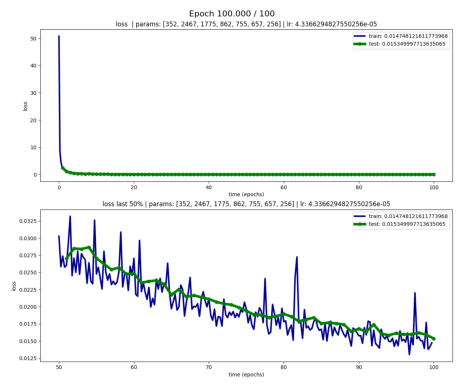

In [9]:
#!g1.4
GLIPH_WIDTH = 256
params = [SVG.ENCODE_HEIGHT * SVG.ENCODE_WIDTH, 2467, 1775, 862, 755, 657, GLIPH_WIDTH]

# lr = 9e-5
lr = 1e-4

model_ae_path = f'models/AE/AE_{SVG.ENCODE_HEIGHT}_{",".join(map(str,params))}/ckpt.pt'
model_ae, optimizer, scheduler = setup_ae(
    params=params,
    lr=lr,
    weight_decay=4e-6,
    line_size=SVG.ENCODE_WIDTH,
    step_size=3,
    step_gamma=0.975,
)
if Path(model_ae_path).exists():
    print('Loaded from file')
    model_ae.load_state_dict(torch.load(model_ae_path))
    img = mpimg.imread(str(Path(model_ae_path).parent / '_loss.png'))
    plt.axis('off')
    plt.imshow(img)
else:
    print('Created new')
model_ae

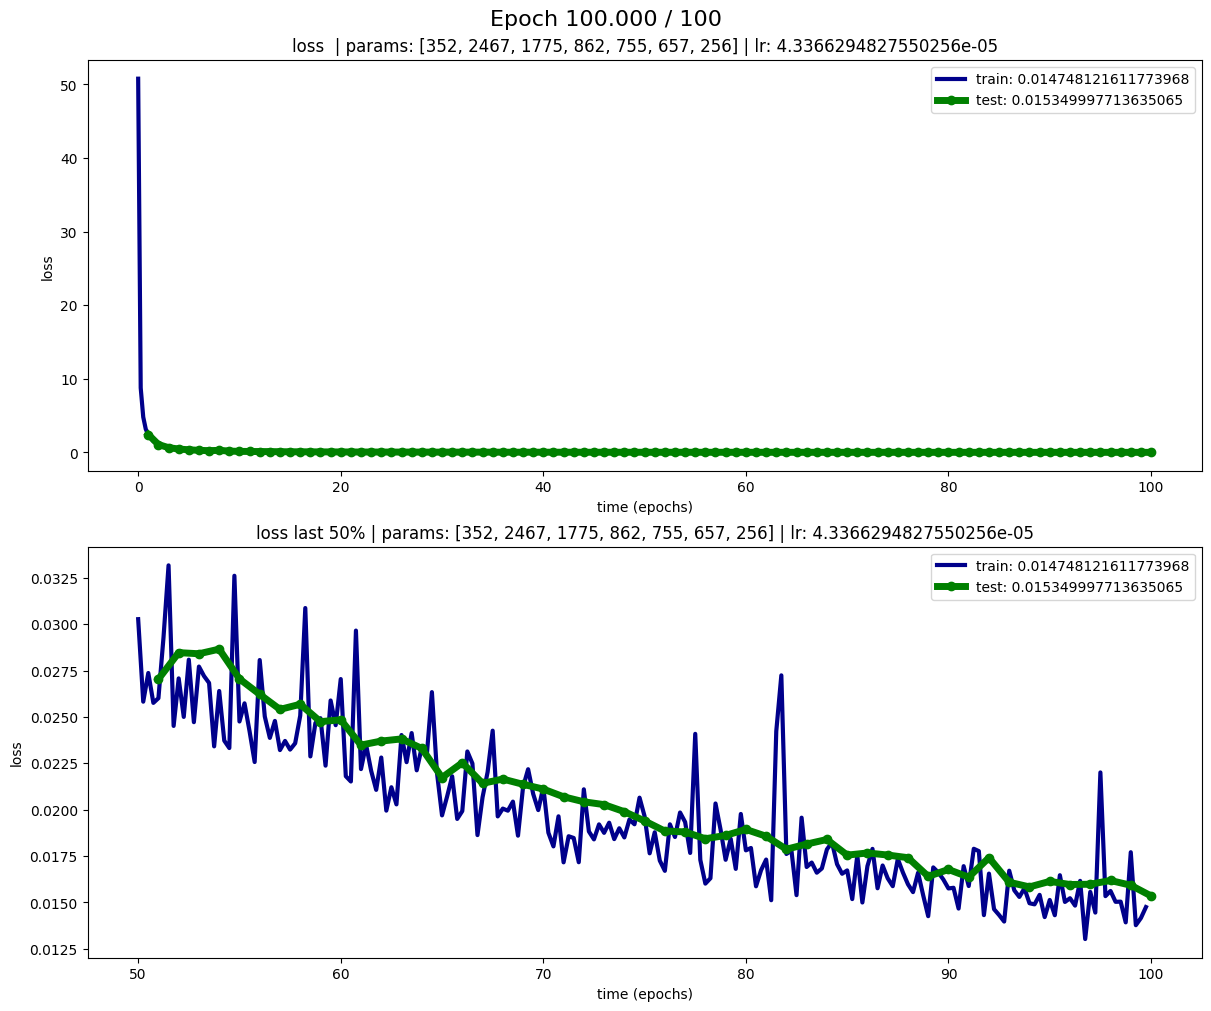

100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [1:38:26<00:00, 65.63s/it]


In [11]:
#!g1.4
run(
    model=model_ae,
    train_dl=train_dataloader,
    test_dl=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=90,
    params=params,
)

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_20260\2562838483.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, imgs_num, i + 1)


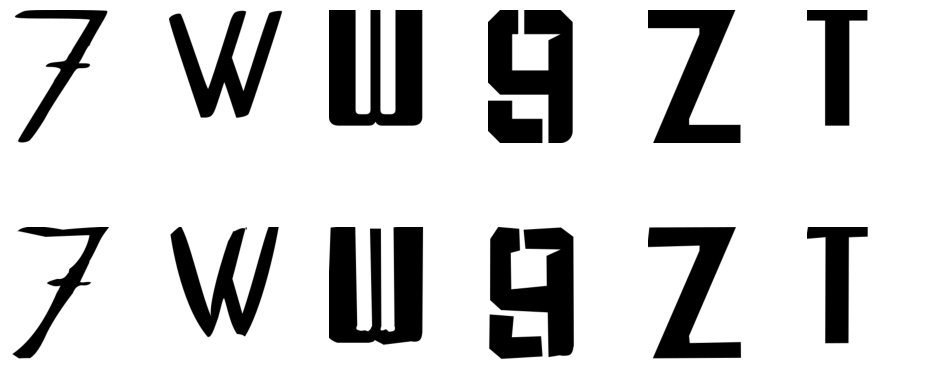

In [10]:
imgs_num = 6
plt.figure(figsize=(2 * imgs_num, 8))
plt.axis('off')

samples, _, _ = dataset_train[400*imgs_num:(400 + 100)*imgs_num: 100]
model_ae.eval()
processed_samples = to_numpy(model_ae(torch.Tensor(samples).to(device)))

for i in range(imgs_num):
    plt.subplot(3, imgs_num, i + 1)
    plt.axis('off')
    show_sampled(samples[i])
for i in range(imgs_num):
    plt.subplot(3, imgs_num, imgs_num + i + 1)
    plt.axis('off')
    show_sampled(processed_samples[i])
plt.show()

In [11]:
def decode_img(d):
    model_ae.eval()
    with torch.no_grad():
        return model_ae.decode(d)

def encode_img(d):
    model_ae.eval()
    with torch.no_grad():
        return model_ae.encode(d)

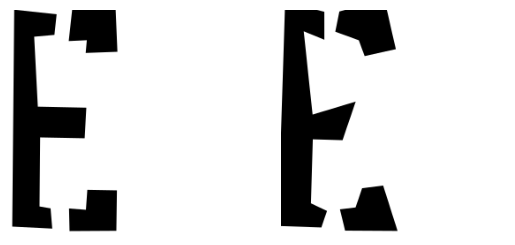

In [12]:
sample, _, _ = dataset_train[2 * 3]

sample = torch.Tensor(sample.reshape((1, -1))).to(device)

sp = encode_img(sample)

plt.subplot(1, 2, 1)
plt.axis('off')
show_sampled(to_numpy(decode_img(sp)[0]))

shift = torch.randn_like(sp) * 0.01

sp += shift

plt.subplot(1, 2, 2)
plt.axis('off')
show_sampled(to_numpy(decode_img(sp)[0]))
plt.show()

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_20260\1767820419.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  sample1 = encode_img(torch.Tensor([sample1]).to(device))


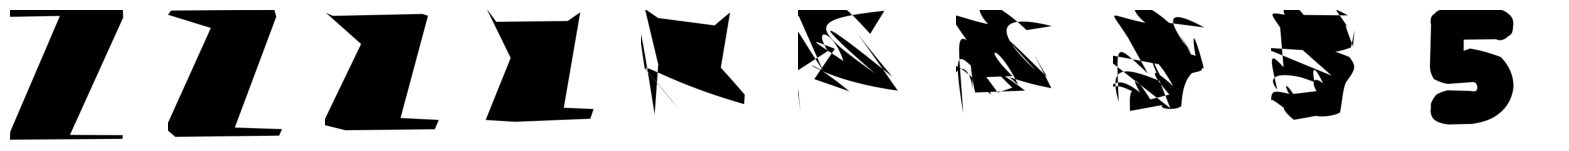

In [13]:
imgs_num = 10

# fig, ax = plt.subplots(nrows=1, ncols=10)
plt.figure(figsize=(2 * imgs_num, 5))
# plt.axis('off')

sample1, _, _ = dataset_train[2000]
sample2, _, _ = dataset_train[1897]

sample1 = encode_img(torch.Tensor([sample1]).to(device))
sample2 = encode_img(torch.Tensor([sample2]).to(device))

for ind, i in enumerate(np.linspace(0, 1, imgs_num)):
    mix = sample1 * i + sample2 * (1 - i)
    plt.subplot(1, imgs_num, ind + 1)
    plt.axis('off')
    show_sampled(to_numpy(decode_img(mix)[0]))
    
plt.show()

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

In [15]:
img = dataset_test[5432][0]

@interact(x=(-1,1,0.01), s=(0, 255))
def f(x=0, s=0):
    tmp = encode_img(torch.Tensor([img]).to(device))
    tmp[0][s] = x
    decoded = decode_img(tmp)
    show_sampled(to_numpy(decoded)[0])

# interact(f, x=FloatSlider(min=-1, max=1))

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), IntSlider(value=0…

## Дифузионная модель

In [14]:
import diffusers
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup, get_constant_schedule

In [44]:
IMG_SIZE = 16
EPOCHS = 50

dataset = ConcatDataset([dataset_train, dataset_test])
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

In [45]:
name = '612_4_mse'
try:
    model = UNet2DModel.from_pretrained(f'models/DiffusionCond/{name}/unet')
    print('Loaded from pretrained')
except Exception as e:
    print(e)
    model = UNet2DModel(
        sample_size=IMG_SIZE,  # the target image resolution
        in_channels=1,  # the number of input channels, 3 for RGB images
        out_channels=1,  # the number of output channels
        layers_per_block=4,  # how many ResNet layers to use per UNet block
        block_out_channels=(64, 128, 256),  # the number of output channes for each UNet block
        down_block_types=( 
            "DownBlock2D",  # a regular ResNet downsampling block
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ), 
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D"  
        ),
        num_class_embeds=len(dl.GLYPH_FILTER),
        class_embed_type='timestep',
    )
model.to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like models/DiffusionCond/612_4_mse/unet is not the path to a directory containing a file named diffusion_pytorch_model.bin or 
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/diffusers/installation#offline-mode'.
Num params:  23642881


UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (class_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel

In [46]:
def make_grid(images, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    axes = axes.flatten()
    
    images = to_numpy(decode_img(images.reshape((-1, GLIPH_WIDTH))))
    for i, image in enumerate(images):
        show_sampled(image, axes[i])
    return fig, axes

def evaluate(epoch):
    torch.manual_seed(12)
    imgs = torch.randn((4, 1, IMG_SIZE, IMG_SIZE), device=device)
    labels = labels2num(['one', 'y', 'z', 'N']).to(device)
    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            residual = model(imgs, t, labels).sample

        imgs = noise_scheduler.step(residual, t, imgs).prev_sample
    
    fig, axes = make_grid(imgs, rows=2, cols=2)

    # Save the images
    test_dir = Path(f'imgs/diffusion_cond/{name}')
    test_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(test_dir / f'{epoch:04d}.png')
    plt.close(fig)

In [54]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=400,
    num_training_steps=(len(dataloader) * EPOCHS),
)
progresser = Progresser(dataloader)
try:
    noise_scheduler = DDPMScheduler.from_pretrained(f'models/DiffusionCond/{name}/scheduler')
    print('Noise sheduler loaded from pretrained')
except Exception as e:
    print(e)
    noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
loss_fn = nn.MSELoss()

We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like models/DiffusionCond/612_4_mse/scheduler is not the path to a directory containing a scheduler_config.json file.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/diffusers/installation#offline-mode'.


In [55]:
global_step = 0

In [ ]:
for epoch in range(progresser.epoch, progresser.epoch + EPOCHS):
    progress_bar = tqdm(total=len(dataloader), position=0, leave=True)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, (svg_images, labels, _) in enumerate(dataloader):
        bs = svg_images.shape[0]

        clean_images = encode_img(svg_images.to(device)).reshape((-1, 1, IMG_SIZE, IMG_SIZE))
        noise = torch.randn(clean_images.shape).to(device)

        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=device).long()

        # forward diffusion process
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Predict the noise residual
        labels = labels2num(labels).to(device)
        noise_pred = model(noisy_images, timesteps, labels, return_dict=False)[0]
        loss = loss_fn(noise_pred, noise)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        progress_bar.set_postfix(**logs)
        global_step += 1
        
        if step % 100 == 0 or step + 1 == len(dataloader):
            progresser.add_train(epoch + step / len(dataloader), loss.detach().item())
    progresser.show_progress(epoch, progresser.epoch + EPOCHS, save_to=f'imgs/cond/{name}.loss.png', clear=False)
    pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    evaluate(epoch)
    pipeline.save_pretrained(f'models/DiffusionCond/{name}')
    torch.save(model.state_dict(), f'models/DiffusionCond/{name}/ckpt.pt')

Epoch 44:  82%|███████████████████████▊     | 4230/5143 [20:55<04:28,  3.40it/s, loss=0.00342, lr=2.99e-6, step=240807]

In [34]:
evaluate(999)

 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [00:21<00:01, 44.69it/s]

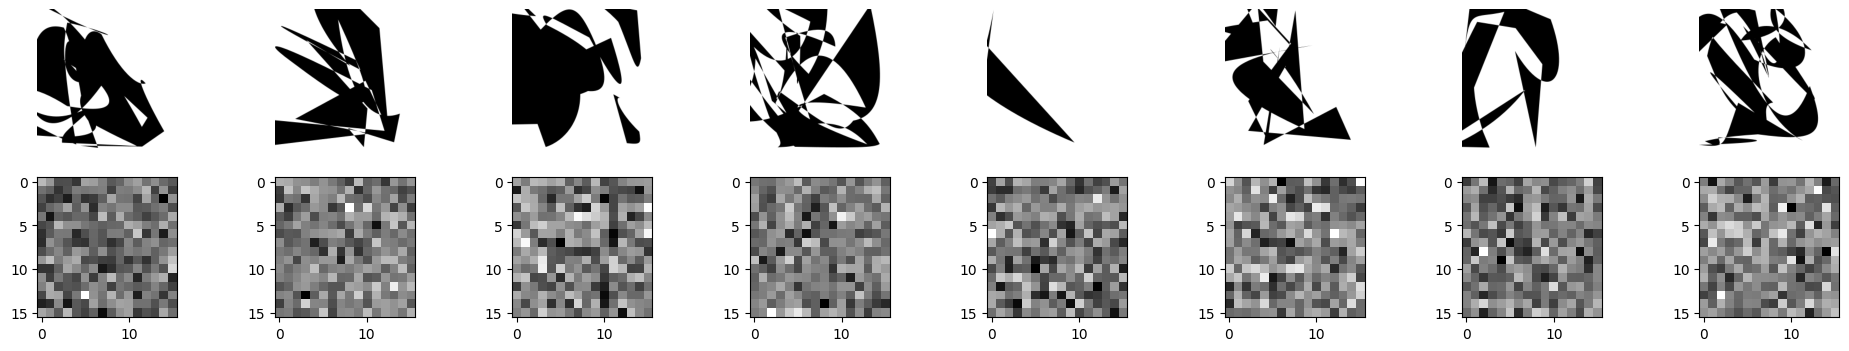

 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [00:22<00:02, 15.14it/s]

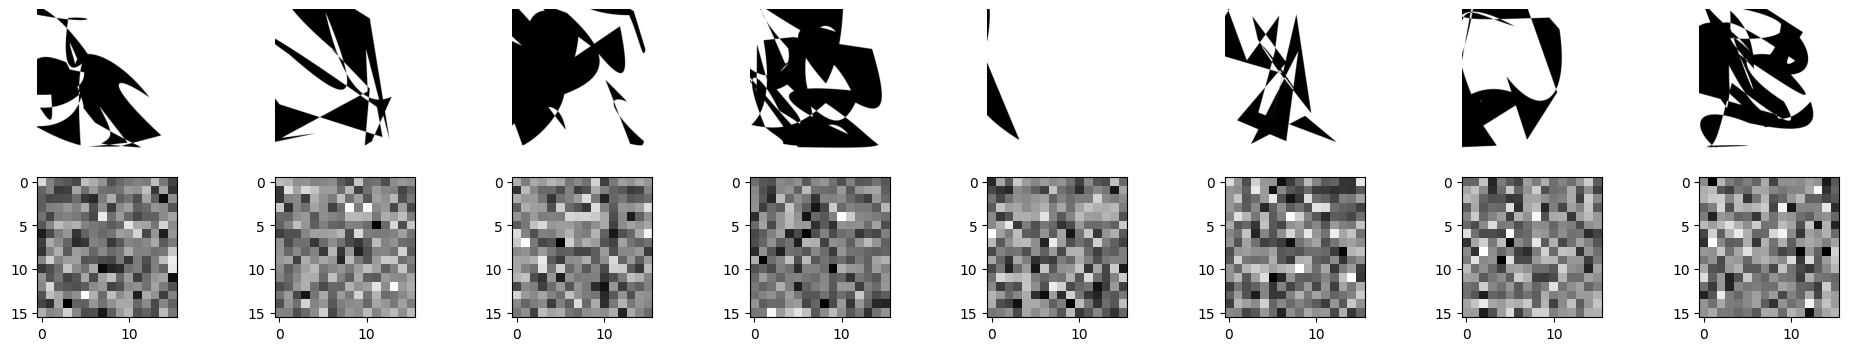

 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [00:23<00:03,  9.83it/s]

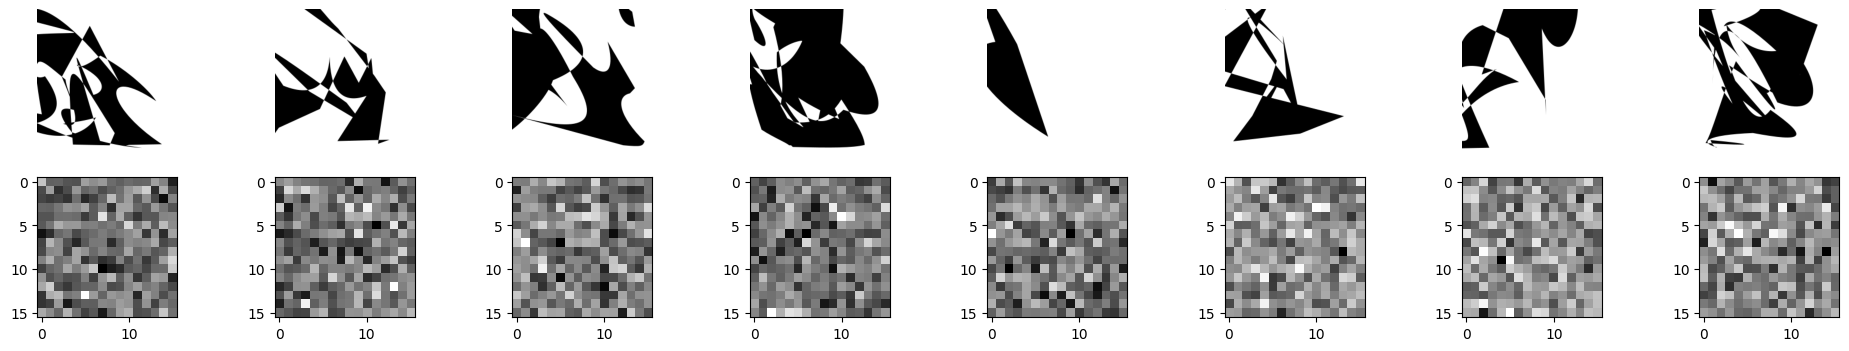

 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [00:24<00:03,  8.05it/s]

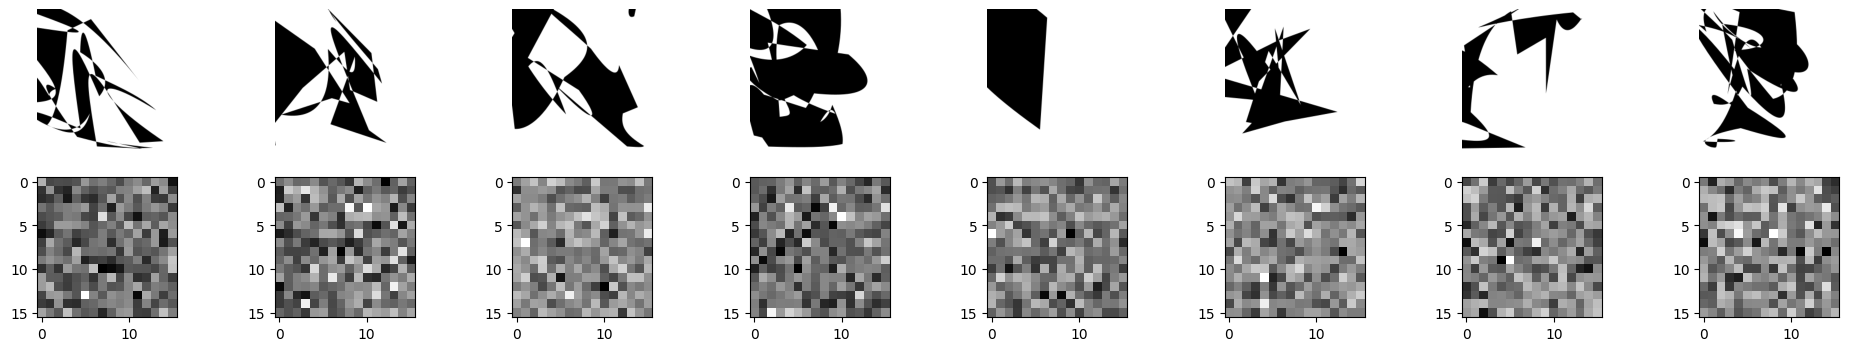

 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:25<00:05,  5.77it/s]

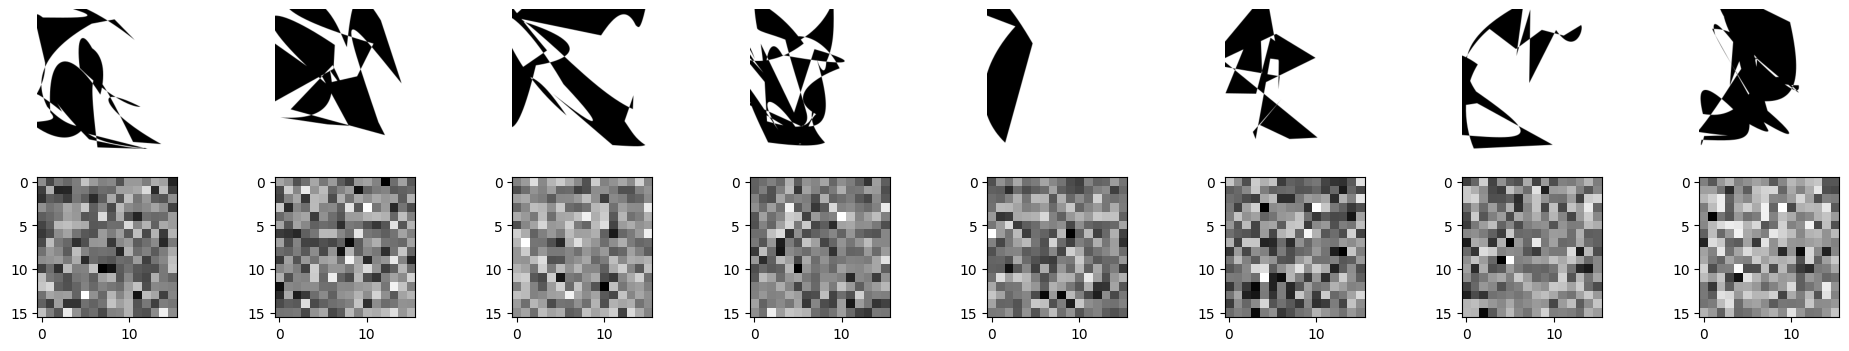

 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [00:25<00:04,  5.79it/s]

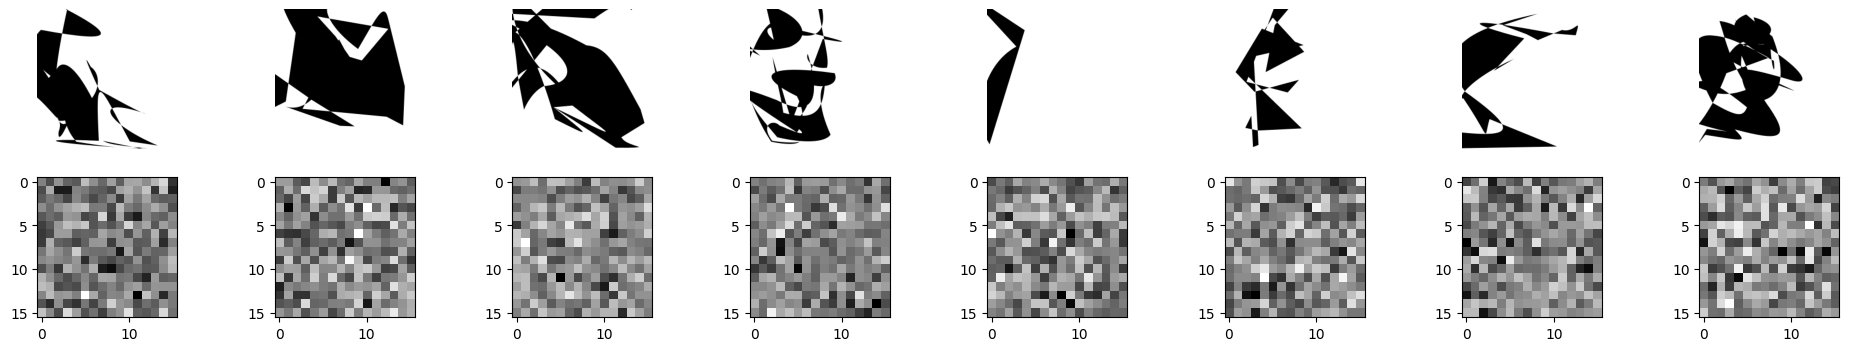

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:26<00:03,  5.84it/s]

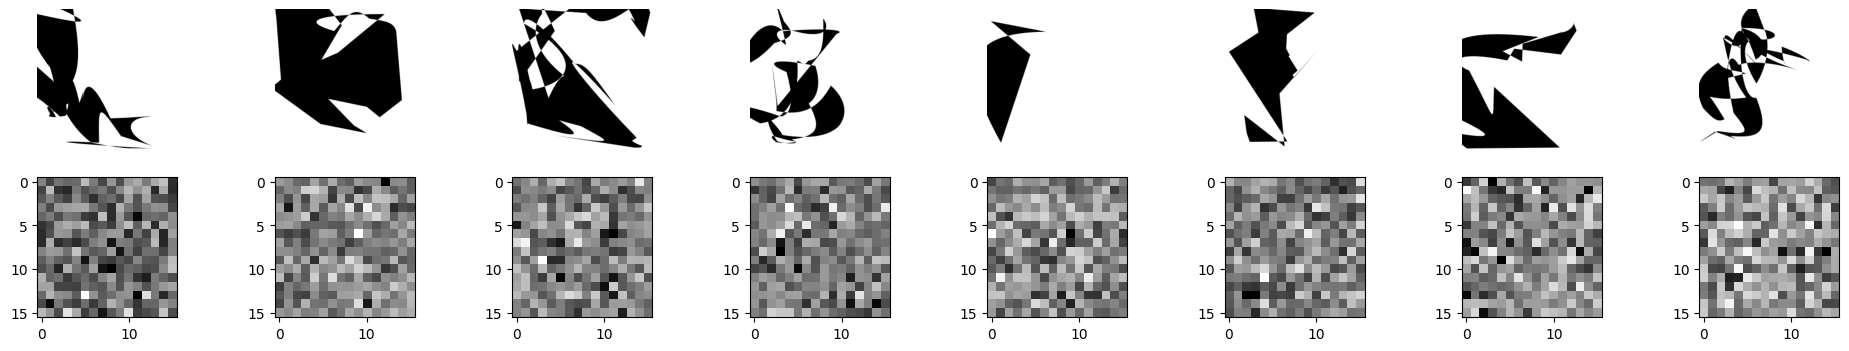

 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [00:27<00:01,  7.46it/s]

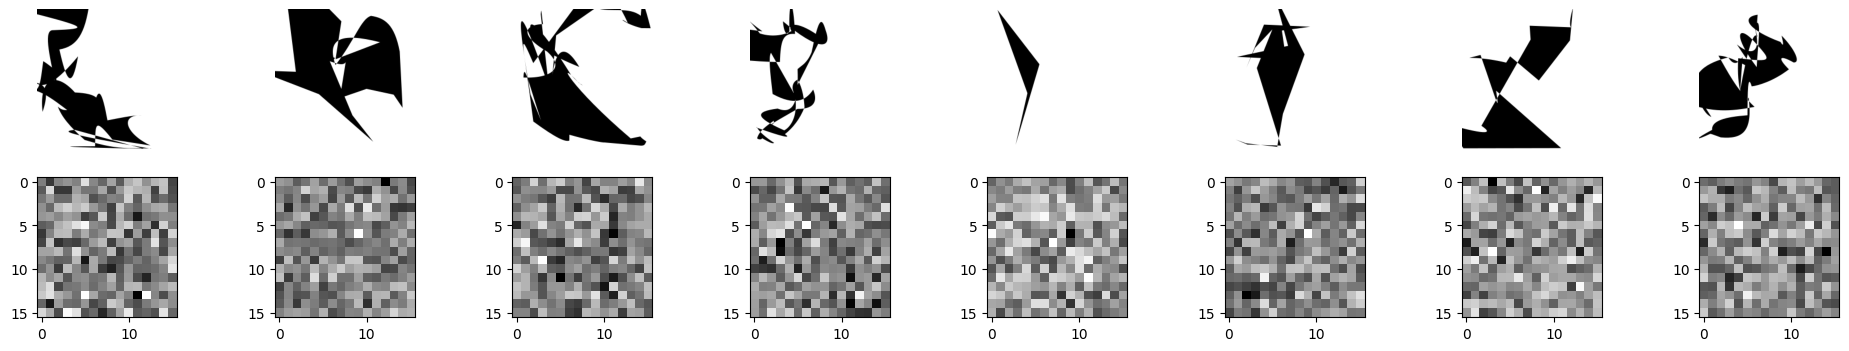

 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [00:28<00:01,  4.87it/s]

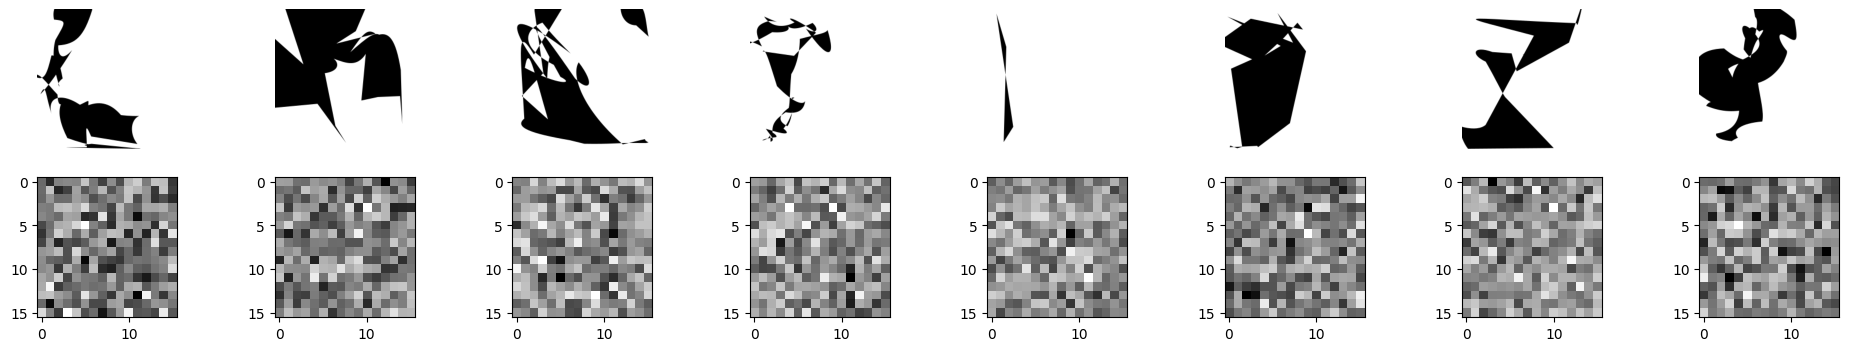

100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [00:29<00:01,  4.87it/s]

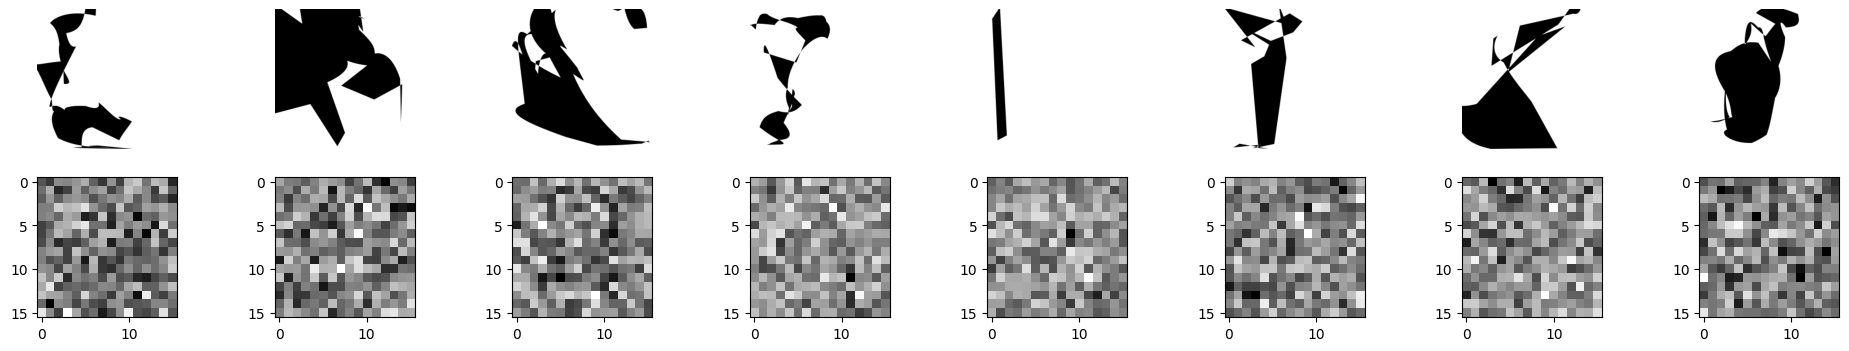

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.65it/s]


In [21]:
def sample(n=1):
    img = torch.randn((n, 1, IMG_SIZE, IMG_SIZE), device=device)

    for t in tqdm(noise_scheduler.timesteps, position=0, leave=True):
        with torch.no_grad():
            residual = model(img, t).sample

        img = noise_scheduler.step(residual, t, img).prev_sample
    return img

def show_sampling():
    n = 8
    imgs = torch.randn((n, 1, IMG_SIZE, IMG_SIZE), device=device)

    for i, t in enumerate(tqdm(noise_scheduler.timesteps, position=0, leave=True)):
        with torch.no_grad():
            residual = model(imgs, t).sample

        imgs = noise_scheduler.step(residual, t, imgs).prev_sample
        if (i + 1) > 950 and (i + 1) % 5 == 0:
            fig, axes = plt.subplots(2, n, figsize=(3*n, 4))
            for j, img in enumerate(imgs):
                svg = to_numpy(decode_img(img.reshape(-1, IMG_SIZE*IMG_SIZE)))[0]
                show_sampled(svg, axes[0][j])
            for j, img in enumerate(imgs):
                axes[1][j].imshow(to_numpy(img[0]), cmap='gray')
            
            plt.show()
            plt.close(fig)
            
show_sampling()

In [65]:
encoded_data = []
for images, _, _ in test_dataloader:
    images = encode_img(images.to(device))
    encoded_data.append(images)

encoded_data = to_numpy(torch.cat(encoded_data, 0))
print("Data shape", encoded_data.shape)
tsne_model = TSNE()
embedding = tsne_model.fit_transform(encoded_data)


Data shape (126663, 256)


 10%|███████▉                                                                        | 99/1000 [00:17<02:42,  5.53it/s]

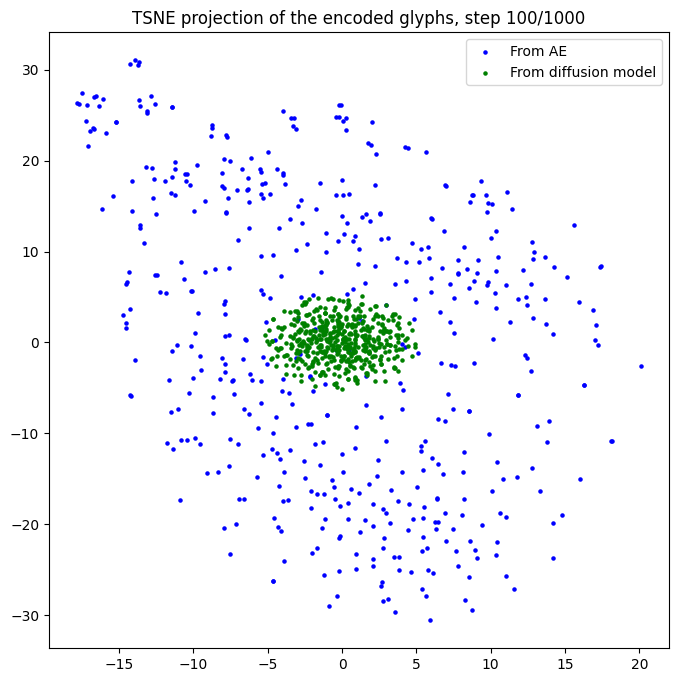

 20%|███████████████▋                                                               | 199/1000 [00:38<02:24,  5.54it/s]

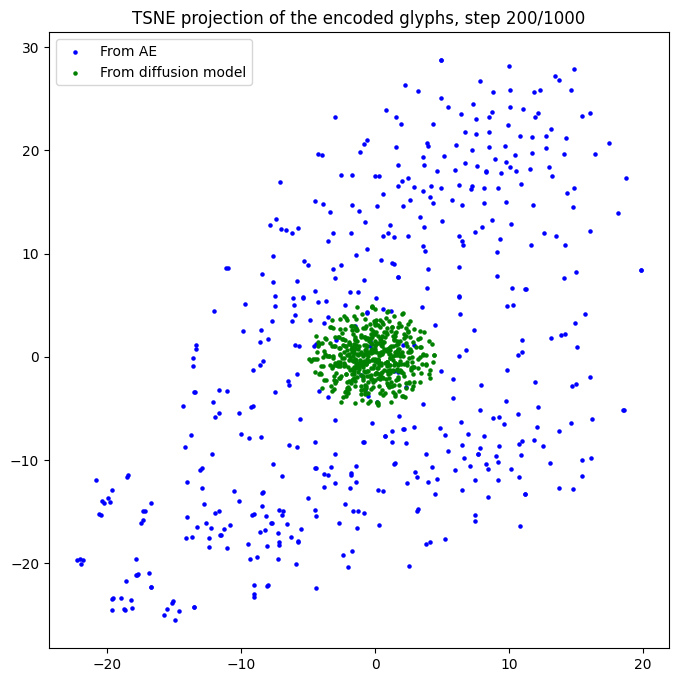

 30%|███████████████████████▌                                                       | 299/1000 [00:58<02:06,  5.53it/s]

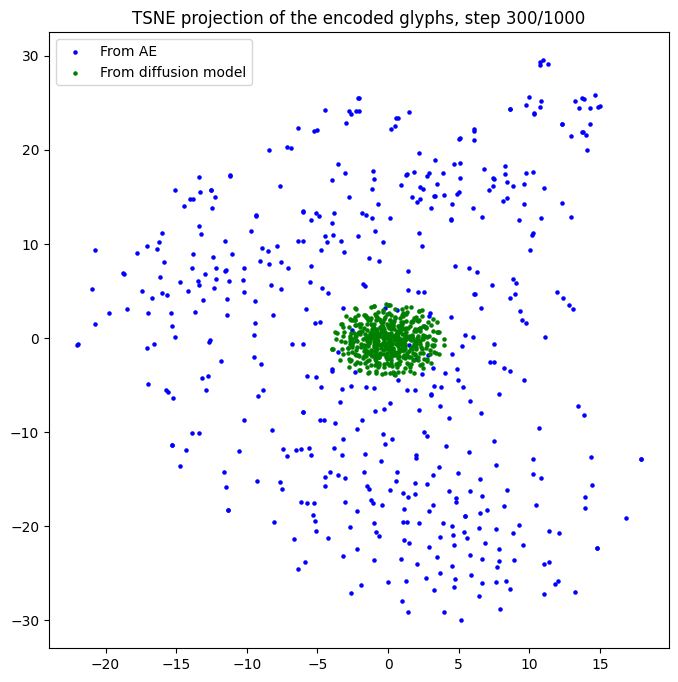

 40%|███████████████████████████████▌                                               | 399/1000 [01:19<01:49,  5.51it/s]

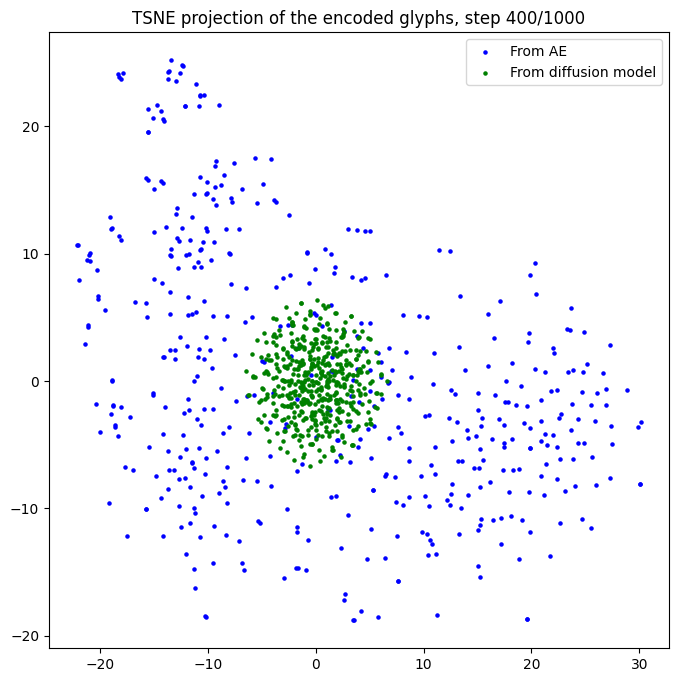

 50%|███████████████████████████████████████▍                                       | 499/1000 [01:40<01:30,  5.51it/s]

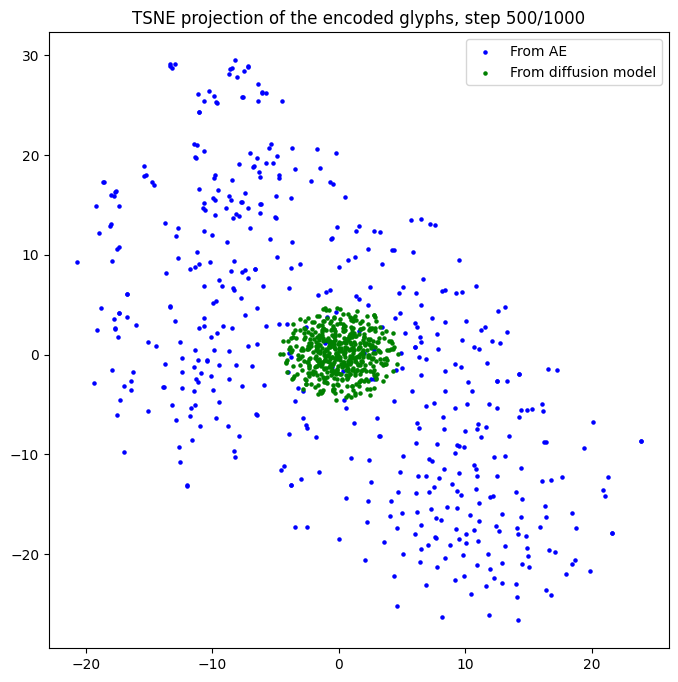

 60%|███████████████████████████████████████████████▎                               | 599/1000 [02:00<01:12,  5.54it/s]

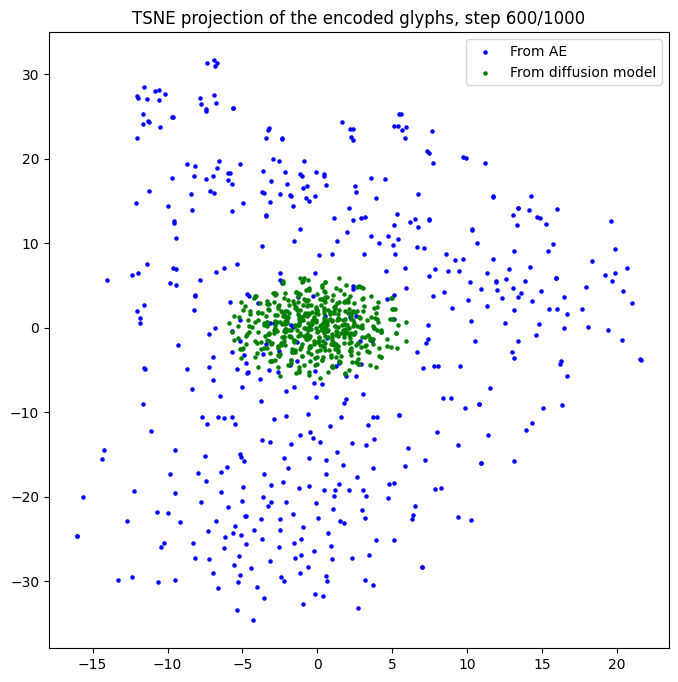

 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [02:20<00:54,  5.54it/s]

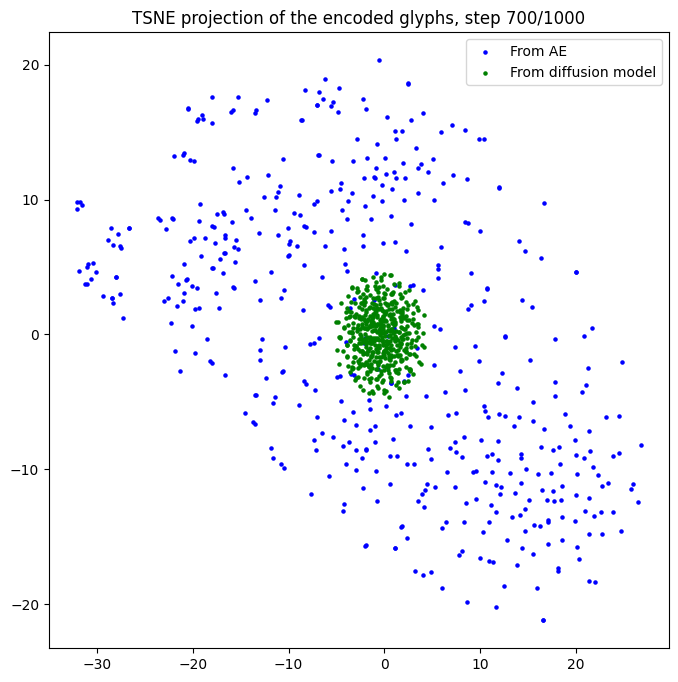

 80%|███████████████████████████████████████████████████████████████                | 799/1000 [02:41<00:36,  5.51it/s]

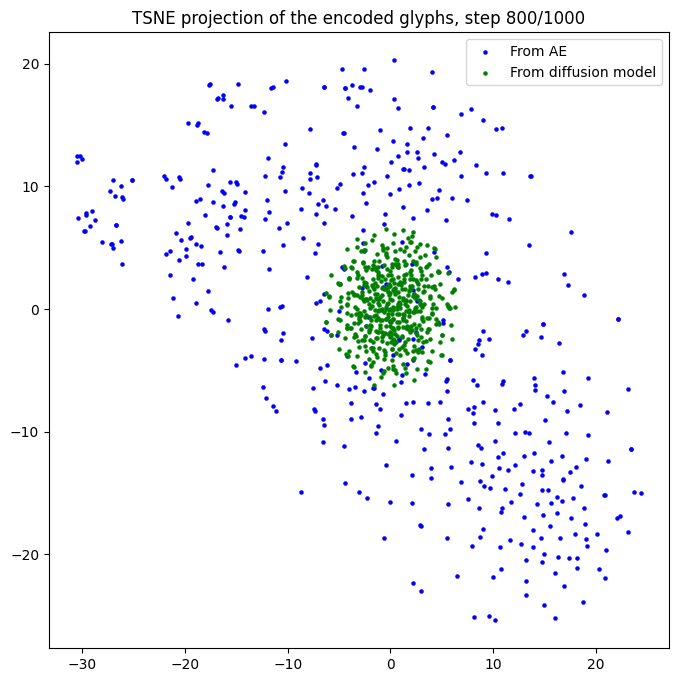

 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [03:01<00:18,  5.50it/s]

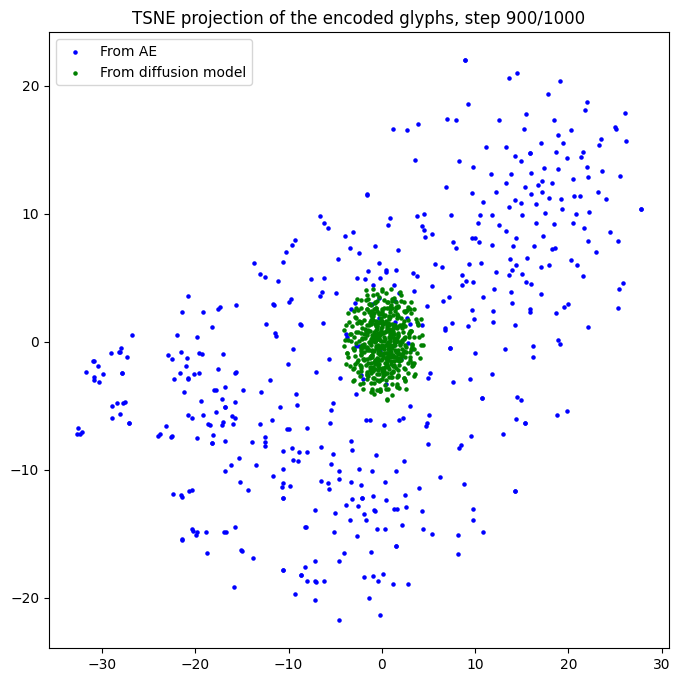

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [03:22<00:00,  5.49it/s]

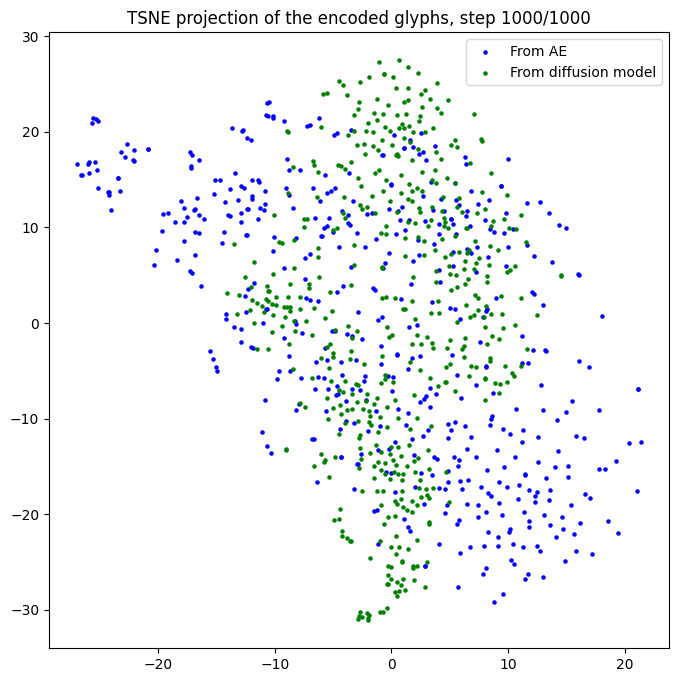

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:24<00:00,  4.89it/s]


In [66]:
imgs = torch.randn((500, 1, IMG_SIZE, IMG_SIZE), device=device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps, position=0, leave=True)):
    with torch.no_grad():
        residual = model(imgs, t).sample

    imgs = noise_scheduler.step(residual, t, imgs).prev_sample
    if (i + 1) % 100 == 0:
        sampled_embedding = tsne_model.fit_transform(to_numpy(imgs.view((sampled.shape[0], -1))))
        orig_embedding = tsne_model.fit_transform(encoded_data[:500])
        
        plt.figure(figsize=(8, 8))

        plt.scatter(
            orig_embedding[:500, 0], orig_embedding[:500, 1], 
            c='b',
            s=5,
            label='From AE',
        )

        plt.scatter(
            sampled_embedding[:, 0], sampled_embedding[:, 1], 
            c='g',
            s=5,
            label='From diffusion model',
        )

        plt.legend()
        plt.title(f'TSNE projection of the encoded glyphs, step {i+1}/1000');
        plt.show()

In [67]:
sampled = sample(500)
sampled_embedding = tsne_model.fit_transform(to_numpy(sampled.view((sampled.shape[0], -1))))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:01<00:00,  5.50it/s]


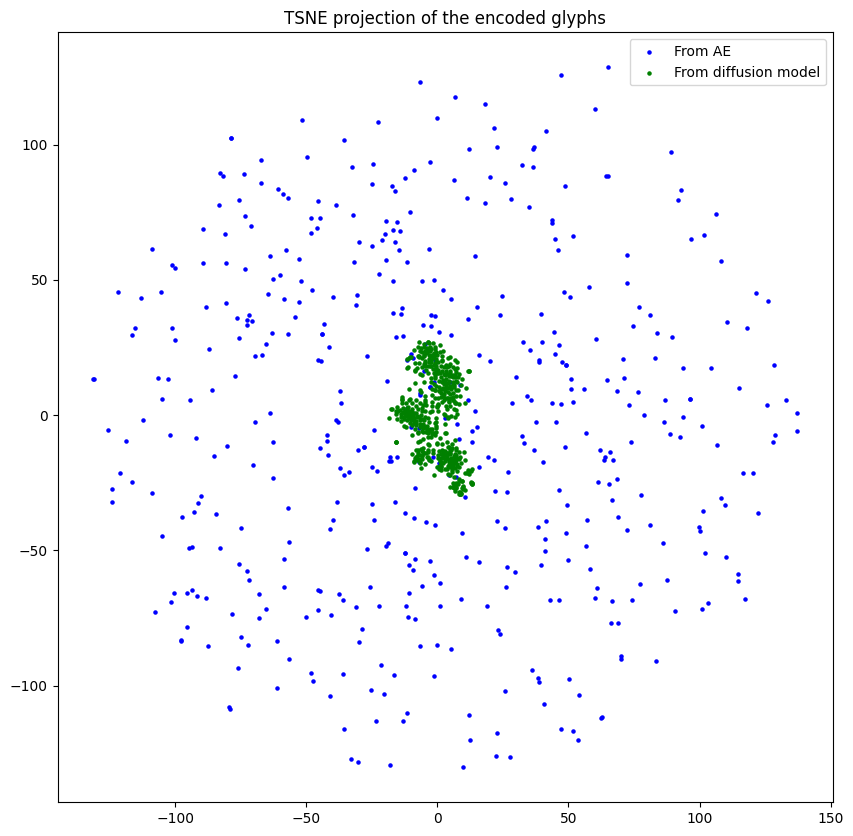

In [68]:
plt.figure(figsize=(10, 10))


plt.scatter(
    embedding[:500, 0], embedding[:500, 1], 
    c='b',
    s=5,
    label='From AE',
)

plt.scatter(
    sampled_embedding[:, 0], sampled_embedding[:, 1], 
    c='g',
    s=5,
    label='From diffusion model',
)

plt.legend()
plt.title('TSNE projection of the encoded glyphs');
plt.show()

In [39]:
encoded_data = []
for images, _, _ in test_dataloader:
    images = encode_img(images.to(device))
    encoded_data.append(images)
    

encoded_data = to_numpy(torch.cat(encoded_data, 0))

In [40]:
print('max', encoded_data.max())
print('min', encoded_data.min())
print('mean', encoded_data.mean())

max 0.5450526
min -0.53985715
mean 0.003183962


In [41]:
print('max', sampled.max())
print('min', sampled.min())
print('mean', sampled.mean())

max tensor(0.4100, device='cuda:0')
min tensor(-0.4754, device='cuda:0')
mean tensor(0.0033, device='cuda:0')
